# Drug DGP

Create balanced treatment assignment.

In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from pathlib import Path
from itertools import product
project_root = (
    Path.cwd()
    .parents[0]
)
sys.path.append(str(project_root))
sys.path.append(str(f'{project_root}/run-simulation/py-files'))
from utils_calibration import calibrate_propensity_score, compute_ipw_estimate, calibration_errors
from utils_dgps import dgp_wrapper

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from scipy.stats import beta



## Base Data

In [21]:
n_obs = 2000
overlap = 0.5

dgp_type="sim_v06_drug"

dgp_dict = {
    'n_obs':n_obs,
    'overlap':overlap}

data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

treatment = data_dict['treatment']
outcome = data_dict['outcome']
m_0 = data_dict['propensity_score']
x = data_dict['covariates']


Treated percentage: 61.20%


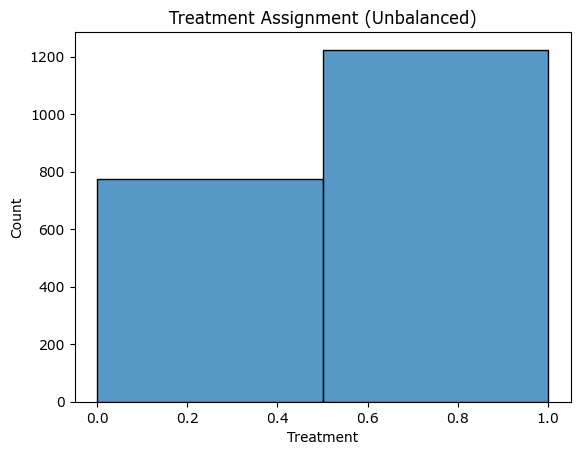

In [22]:
data = pd.DataFrame({
    'X1': x[:,0],
    'X2': x[:,1],
    'X3': x[:,2],
    'D': treatment,
    'Y': outcome,
    'm_oracle': m_0,
    'treatment_effect': [-1] * n_obs
})
print(f"Treated percentage: {data['D'].mean() * 100:.2f}%")

# Step 5: Visualize treatment imbalance
sns.histplot(data['D'], bins=2, kde=False)
plt.title("Treatment Assignment (Unbalanced)")
plt.xlabel("Treatment")
plt.ylabel("Count")
plt.show()

## Estimated propensity score

In [23]:
covariates = ['X1', 'X2', 'X3']

df_train, df_test = train_test_split(data, test_size=0.5, random_state=42)

# Step 6: Fit a Random Forest to estimate the propensity scores
model = RandomForestClassifier(n_estimators=200, random_state=42)
#model = LogisticRegression(random_state=42)
model.fit(df_train[covariates], df_train['D'])

for df in [df_train, df_test]:
    df['m_hat'] = model.predict_proba(df[covariates])[:, 1]

    calibrator = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
    df['m_calibrated'] = calibrator.fit_transform(df['m_hat'], df['D'])

df_train.head()

,X1,X2,X3,D,Y,m_oracle,treatment_effect,m_hat,m_calibrated
440,0.0,56.356133,0.460435,1,5,0.822556,-1,0.875,1.0
573,1.0,57.711232,0.855114,1,6,0.906115,-1,0.965,1.0
946,0.0,43.881830,0.511292,0,8,0.488151,-1,0.330,0.0
997,0.0,46.555424,0.267957,0,4,0.502323,-1,0.180,0.0
503,1.0,50.355966,0.613813,0,3,0.697256,-1,0.180,0.0


## Define weights

In [24]:
clipping_threshold = 1e-12

for df in [df_train, df_test]:
    for ps in ['m_oracle', 'm_hat', 'm_calibrated']:
        ps_clipped = df[ps].clip(clipping_threshold, 1.0 - clipping_threshold)

        df[f'{ps}_ate_weights'] = df['D'] / ps_clipped + (1 - df['D']) / (1 - ps_clipped)
        df[f'{ps}_att_weights'] = df['D'] + (1 - df['D']) * ps_clipped / (1 - ps_clipped)

## Save Data

In [25]:
dgp_name = "drug"
df_train.to_csv(f'results/{dgp_name}_train.csv', index=False)
df_test.to_csv(f'results/{dgp_name}_test.csv', index=False)

## Add additional methods

In [26]:
import os

os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.1.0'
os.environ['PATH'] = os.environ['R_HOME'] + '\\bin\\x64;' + os.environ['PATH']

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, isinstalled, importr

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import os
# Set environment variables
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.3.0' 
os.environ['PATH'] = os.environ['R_HOME'] + '\\bin\\x64;' + os.environ['PATH']
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
#from rpy2.robjects.packages import importr, isinstalled,

# Set environment variables for R
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.3.0'  # Replace with your actual R installation path
os.environ['PATH'] = os.environ['R_HOME'] + '\\bin\\x64;' + os.environ['PATH']


# Activate pandas2ri conversion
pandas2ri.activate()


clipping_threshold = 1e-12
np.random.seed(42)

# Estimate rebalancing weights and propensity scores of alternative methods on full data set

weightit_pkg = importr('WeightIt')
# Define the formula for WeightIt
formula = robjects.Formula('D ~ X1 + X2 + X3')

data = pd.DataFrame({
    'X1': x[:,0],
    'X2': x[:,1],
    'X3': x[:,2],
    'D': treatment,
    'Y': outcome,
    'm_oracle': m_0,
    #'treatment_effect': [-1] * n_obs
})

for method in ['glm', 'optweight', 'ebal', 'ipt','cbps']:

    data_r = pandas2ri.py2rpy(data)
    weightit_ate = robjects.r['weightit'](formula, data=data_r, estimand="ATE", method=method)
    weightit_att = robjects.r['weightit'](formula, data=data_r, estimand="ATT", method=method)

    weights_ate = weightit_ate.rx2('weights')
    ate_estimate= weightit_ate.rx2('estimand')

    weights_att = weightit_att.rx2('weights')
    att_estimate= weightit_att.rx2('estimand')
    # Calculate the propensity scores based on weights and treatment assignment
    propensity_scores = data['D'] / weights_ate + (1 - data['D'])*(1-1/(weights_ate))
    data[f'm_{method}_ate'] = propensity_scores.clip(clipping_threshold, 1.0 - clipping_threshold)
    propensity_scores = (weights_att - data['D']) / ((1-data['D']) + (weights_att-data['D'])) 
    data[f'm_{method}_att'] = propensity_scores.clip(clipping_threshold, 1.0 - clipping_threshold)

    data[f'm_{method}_ate_weights'] = weights_ate
    data[f'm_{method}_att_weights'] = weights_att

# Split the data into training and testing sets
covariates = ['X1', 'X2', 'X3']
df_train, df_test = train_test_split(data, test_size=0.5, random_state=42)

# Fit a Logistic Regression to estimate the propensity scores
model = LogisticRegression(random_state=42)
model.fit(df_train[covariates], df_train['D'])
#weights_cobalt = []

for df in [df_train, df_test]:
    df['m_hat'] = model.predict_proba(df[covariates])[:, 1]
    calibrator = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1)
    df['m_calibrated'] = calibrator.fit_transform(df['m_hat'], df['D'])

df_train.head()

,X1,X2,X3,D,Y,m_oracle,m_glm_ate,m_glm_att,m_glm_ate_weights,m_glm_att_weights,...,m_ipt_ate,m_ipt_att,m_ipt_ate_weights,m_ipt_att_weights,m_cbps_ate,m_cbps_att,m_cbps_ate_weights,m_cbps_att_weights,m_hat,m_calibrated
440,0.0,56.356133,0.460435,1,5,0.822556,0.692997,NaN,1.443007,1.000000,...,0.685265,NaN,1.459290,1.000000,0.698910,NaN,1.430799,1.000000,0.691062,0.701754
573,1.0,57.711232,0.855114,1,6,0.906115,0.853122,NaN,1.172165,1.000000,...,0.844481,NaN,1.184159,1.000000,0.857552,NaN,1.166110,1.000000,0.833973,0.833333
946,0.0,43.881830,0.511292,0,8,0.488151,0.621186,0.621186,2.639818,1.639818,...,0.622317,0.622317,2.647724,1.647724,0.624533,0.622317,2.663350,1.647724,0.632499,0.522167
997,0.0,46.555424,0.267957,0,4,0.502323,0.510210,0.510210,2.041692,1.041692,...,0.506252,0.506252,2.025327,1.025327,0.512571,0.506252,2.051581,1.025327,0.533903,0.487179
503,1.0,50.355966,0.613813,0,3,0.697256,0.723389,0.723389,3.615181,2.615181,...,0.727408,0.727408,3.668488,2.668488,0.727115,0.727408,3.664544,2.668488,0.714781,0.761194


In [28]:
clipping_threshold = 0.01

for df in [df_train, df_test]:
    for ps in ['m_oracle', 'm_hat', 'm_calibrated','m_ipt_ate', 'm_ebal_ate','m_glm_ate', 'm_cbps_ate', 'm_optweight_ate']:
        ps_clipped = df[ps].clip(clipping_threshold, 1.0 - clipping_threshold)

        df[f'{ps}_ate_weights'] = df['D'] / ps_clipped + (1 - df['D']) / (1 - ps_clipped)
        df[f'{ps}_att_weights'] = df['D'] + (1 - df['D']) * ps_clipped / (1 - ps_clipped)

In [29]:
dgp_name = "drug_2"

df_train.to_csv(f'results/{dgp_name}_train.csv', index=False)
df_test.to_csv(f'results/{dgp_name}_test.csv', index=False)